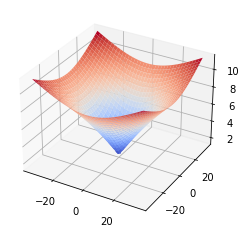

Found minimum at [-0.12814500000000092, 2.8876500000000034] with value: 1.8714334110290238, it took 12 iterations.


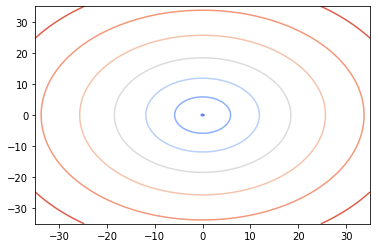

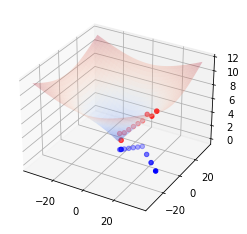

Found minimum at [-0.63774838  0.14658777] with value: 2.285664585031814, it took 600 iterations. Maximum iterations reached


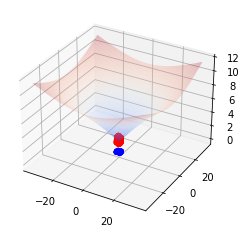

Using Genetic Algorithm found minimum at [-0.07158337  0.15418588] with value: 1.123165754008884, it took 50 iterations.


In [1]:
# Import packages
import numpy as np
from random import shuffle, randint
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate ackley 
def ackley(X, Y):
    Z = np.zeros((len(X), len(Y)))
    
    factor_1 = -0.02 * np.sqrt(0.5 * (X * X + Y * Y))
    factor_2 = 0.5 * (np.cos(2 * np.pi * X + np.cos(2 * np.pi * Y)))
    
    Z = -20 * np.exp(factor_1) - np.exp(factor_2) + np.exp(1) + 20

    return Z

# Define plotting ackley
def plot_ackley (X, Y, Z, path=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=(0.25,1)[path == None])
    if (path != None):
        ax.scatter(path[0], path[1], [ackley_scalar(path[0][i], path[1][1]) for i in range(0, len(path[0]))], color='red')
        ax.scatter(path[0], path[1], color='blue')
    plt.show()

# Define plotting ackley contour
def plot_ackley_contour (X, Y, Z):
    ax = plt.axes()
    ax.contour(X, Y, Z, cmap=cm.coolwarm)

# Calculate ackley scalar value
def ackley_scalar (x, y):
    factor_1 = -0.02 * np.sqrt(0.5 * (x * x + y * y))
    factor_2 = 0.5 * (np.cos(2 * np.pi * x + np.cos(2 * np.pi * y)))

    return -20 * np.exp(factor_1) - np.exp(factor_2) + np.exp(1) + 20

# Calculate gradient of ackley function
def ackley_gradient (x, y, h):
    dfdx = (ackley_scalar(x + h, y) - ackley_scalar(x, y)) / h
    dfdy = (ackley_scalar(x, y + h) - ackley_scalar(x, y)) / h
    return np.array([dfdx, dfdy])

# Find minimum using Hook-Jeeves algorithm
def hooke_jeeves (start_point, step_length, tolerance, step_factor):
    B_x = [[1,0],[-1,0],[0,0]]
    B_y = [[0,1],[0,-1],[0,0]] 
    best_coord = start_point
    best_value = ackley_scalar(start_point[0], start_point[1])
    temp_coord = best_coord
    temp_value = best_value
    iter = 0
    path_x = []
    path_y = []
    
    while step_length >= tolerance:

        # Chose best point from X axis
        for possible_step in B_x:
            test_value = ackley_scalar(best_coord[0] + possible_step[0] * step_length, best_coord[1] + possible_step[1] * step_length)
            if test_value < best_value and test_value < temp_value:
                temp_value = test_value
                temp_coord = [best_coord[0] + possible_step[0] * step_length, best_coord[1] + possible_step[1] * step_length]

        # Chose best point from Y axis
        for possible_step in B_y:
            test_value = ackley_scalar(temp_coord[0] + possible_step[0] * step_length, temp_coord[1] + possible_step[1] * step_length)
            if test_value < best_value and test_value < temp_value:
                temp_value = test_value
                temp_coord = [temp_coord[0] + possible_step[0] * step_length, temp_coord[1] + possible_step[1] * step_length]

        # Calculate vector
        slope_vector = [temp_coord[0] - best_coord[0], temp_coord[1] - best_coord[1]]

        # Move point along the vector until find worse value
        while temp_value < best_value:
            best_coord = temp_coord
            best_value = temp_value
            temp_coord = best_coord[0] + slope_vector[0], best_coord[1] + slope_vector[1]
            temp_value = ackley_scalar(temp_coord[0], temp_coord[1])
            iter += 1
            path_x.append(best_coord[0])
            path_y.append(best_coord[1])

        # Reduct step length
        step_length *= step_factor

    return {
        'best_coord': best_coord,
        'best_value': best_value,
        'iterations': iter,
        'path': [path_x, path_y]
    }

# Find minimum using Gradient Descent algorithm
def grad_descent(start_point, tolerance, step_factor, max_iter, h):
    prev_step = start_point - tolerance
    step = start_point
    iter = 0
    path_x = []
    path_y = []

    while iter < max_iter:
        if (tolerance > np.linalg.norm(step - prev_step)):
            break

        prev_step = step.copy()
        
        vector = - step_factor * ackley_gradient(step[0], step[1], h)
        step += vector

        iter += 1

        path_x.append(step[0])
        path_y.append(step[1])

    return {
        'best_coord': step,
        'best_value': ackley_scalar(step[0], step[1]),
        'iterations': iter,
        'max_iter_r': (False, True)[iter == max_iter],
        'path': [path_x, path_y]
    }

# Find minimum using Genetic Algorithm (GA)
def genetic_algorithm (init_population, inheritance_power, bastard_probability, n_generation):

    # Init population and calculate value of individuals
    population = []
    for coord in init_population:
        population.append({'coord': np.array(coord), 'value': ackley_scalar(coord[0], coord[1])})

    # Evolute generations
    for generation in range(0, n_generation):

        # Randomly mix individuals
        shuffle(population)

        # Divide population and groupe in couples
        females = population[0:int(len(population)/2)]
        males = population[int(len(population)/2):]

        grouped_population = list(zip(females, males))
        population = []

        # For every couple create two children - reproduction
        for couple in grouped_population:
            worse = max(couple, key=lambda c: c['value'])
            better = min(couple, key=lambda c: c['value'])

            # Create new DNA, mutate the DNA if the children is a bastard
            vector = np.array([(better['coord'][0] - worse['coord'][0]) * (-1,1)[randint(0,100) > 100 * bastard_probability], (better['coord'][1] - worse['coord'][1]) * (-1,1)[randint(0,100) > 100 * bastard_probability]])

            # Inject the DNA to a new child
            child_2_coord = worse['coord'] + vector * inheritance_power

            # Create a new population - succession
            population.extend([better,{'coord': child_2_coord, 'value': ackley_scalar(child_2_coord[0], child_2_coord[1])}])

    # Select best solution final population
    solution = min(population, key=lambda c: c['value'])
    return {
        'best_coord': solution['coord'],
        'best_value': solution['value'],
        'iterations': n_generation
    }

# Prepare range
wek_x = np.arange(-35,36,1)
wek_y = np.arange(-35,36,1)

X, Y = np.meshgrid(wek_x, wek_y)

# Calculate ackley and plot
Z = ackley(X, Y)

plot_ackley(X, Y, Z)

plot_ackley_contour(X, Y, Z)

# Init variables for searching minimum
SP = np.array([35.0,-14.0])     # Starting position 
SL = 6.5                        # Initial step length
E = 0.01                        # Tolerance, minimum step length
SF = 0.3                        # Step factor, step length reduction 

# Run Hook-Jeeves algorithm
result = hooke_jeeves(SP, SL, E, SF)
print(f"Found minimum at {result['best_coord']} with value: {result['best_value']}, it took {result['iterations']} iterations.")

plot_ackley(X, Y, Z, result['path'])

# cont. Init variables for searching minimum
h = 0.00001                       # Derivative distance factor 
MI = 600                        # Maximum allowed iterations (GD)

# Run Gradient Descent algorithm
result = grad_descent(SP, E, SF, MI, h)
print(f"Found minimum at {result['best_coord']} with value: {result['best_value']}, it took {result['iterations']} iterations.", ('','Maximum iterations reached')[result['max_iter_r']])

plot_ackley(X, Y, Z, result['path'])


# cont. Init variables for GA                                
SPs = np.array([[35.0,-32.0],[-17.5,19.0],[-9.5,11.0],[-32.0,-21.0],[-7.5,-13.0],[28.0,11.5]])
                                # Starting population
BP = 0.2                        # Bastardness (mutation occure) probability
N_GEN = 50                      # Number of generations to simulate

# Run Genetic Algorithm
result = genetic_algorithm(SPs, SF, 0.2, 50)
print(f"Using Genetic Algorithm found minimum at {result['best_coord']} with value: {result['best_value']}, it took {result['iterations']} iterations.")